In [1]:
%load_ext autoreload
%autoreload 2
import gymnasium as gym
from pprint import pprint
from torch import nn
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plots

## Manual Control

In [7]:
# Human can play the game manually which can act as a baseline for expected returns. The best I can do is ~39 (undiscounted)
env_render = gym.make("highway-v0", render_mode = "human")
state, _ = env_render.reset()

terminated = False
truncated = False

env_render.unwrapped.configure({
    "manual_control": True,
    "vehicles_count": 2,
})

r = 0
steps = 0
while not (terminated or truncated):
    action = env_render.action_space.sample()
    env_render.render()
    next_state, reward, terminated, truncated, _ = env_render.step(action)
    steps += 1
    state = next_state
    r += reward
    # print(f"Returns: {reward}", end='\r')

print(steps)
env_render.close()

22


## Actor Critic Method

In [3]:
class Actor(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.actor_net = nn.Sequential(
            nn.Linear(25, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 5),
            nn.Softmax(dim=0))
    
    def forward(self, state:torch.Tensor):
        state = torch.flatten(state)
        return self.actor_net(state)
    
class Critic(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.critic_net = nn.Sequential(
            nn.Linear(25, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1))
    
    def forward(self, state:torch.Tensor):
        state = torch.flatten(state)
        return self.critic_net(state)
    
class ActorCriticAgent(object):
    def __init__(self):
        # Create the actor and critic networks
        self.device = "cuda"
        self.actor_net = Actor().to(self.device)
        self.critic_net = Critic().to(self.device)

    def get_action(self, state:np.ndarray) -> tuple[int, torch.Tensor]:
        state_tensor = torch.tensor(state).to(self.device)
        action_probs = self.actor_net(state_tensor)
        probs = torch.distributions.Categorical(action_probs)
        action = probs.sample()
        log_prob = probs.log_prob(action)
        return action.item(), log_prob
    
    def get_value(self, state:np.ndarray) -> torch.Tensor:
        state_tensor = torch.tensor(state).to(self.device)
        state_value = self.critic_net(state_tensor)
        return state_value

In [14]:
class ActorCriticTrainer(object):
    def __init__(self, agent:ActorCriticAgent, env:gym.Env, params:dict):
        # Agent object
        self.agent = agent
        
        # Environment object
        self.env = env
        
        # Training parameters
        self.params = params

        # Gamma
        self.gamma = params['gamma']

        # Optimizer
        self.actor_optimizer = torch.optim.Adam(self.agent.actor_net.parameters(), lr=self.params['learning_rate_actor'])
        self.critic_optimizer = torch.optim.Adam(self.agent.critic_net.parameters(), lr=self.params['learning_rate_critic'])

    def run_train(self):        
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []
        
        # Training loop
        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            state, _ = self.env.reset()
            terminated = False
            truncated = False
            I = 1
            G = 0

            # print("\nEpisode: ", ep)
            while not (terminated or truncated):
                action, ln_action_prob  = self.agent.get_action(state)
                # print(action, end='-')
                state_val = self.agent.get_value(state)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_state_val = self.agent.get_value(next_state)
                
                if terminated:
                    next_state_val *= 0
                    
                delta :torch.Tensor = reward + (self.gamma*next_state_val) - state_val
                delta = delta.to(self.agent.device)
                
                value_loss :torch.Tensor = nn.functional.mse_loss(reward + self.gamma * next_state_val, state_val)
                value_loss = value_loss.to(self.agent.device)
                
                policy_loss :torch.Tensor = -delta.detach() * ln_action_prob
                policy_loss.to(self.agent.device)

                total_loss = value_loss + policy_loss

                self.actor_optimizer.zero_grad()
                policy_loss.backward()
                self.actor_optimizer.step()
                
                self.critic_optimizer.zero_grad()
                value_loss.backward()
                self.critic_optimizer.step()

                G += (reward * I)
                I *= self.gamma
                state = next_state

            loss = float(total_loss)

            # Save the return and loss
            train_returns.append(G)
            train_losses.append(total_loss.item())
            
            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")
        
        return train_returns, train_losses

In [30]:
if __name__ == "__main__":
    my_env = gym.make("highway-fast-v0")

    train_params = {
        'num_episodes': 500,
        'num_trials': 1,
        'learning_rate_actor': 1e-5,
        'learning_rate_critic': 1e-3,
        'gamma': 0.99
    }

    actor_critic_returns = []
    actor_critic_losses = []

    for _ in range(train_params['num_trials']):
        # my_agent = ActorCriticAgent()
        my_agent = ActorCriticAgent()
        my_trainer = ActorCriticTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()
        
        actor_critic_returns.append(returns)
        actor_critic_losses.append(losses)

np.save("actor_critic_returns_2", actor_critic_returns)
np.save("actor_critic_losses_2", actor_critic_losses)

Episode: 499 | Return: 3.7559134042010673 | Loss: -0.89: 100%|██████████| 500/500 [05:05<00:00,  1.64it/s]


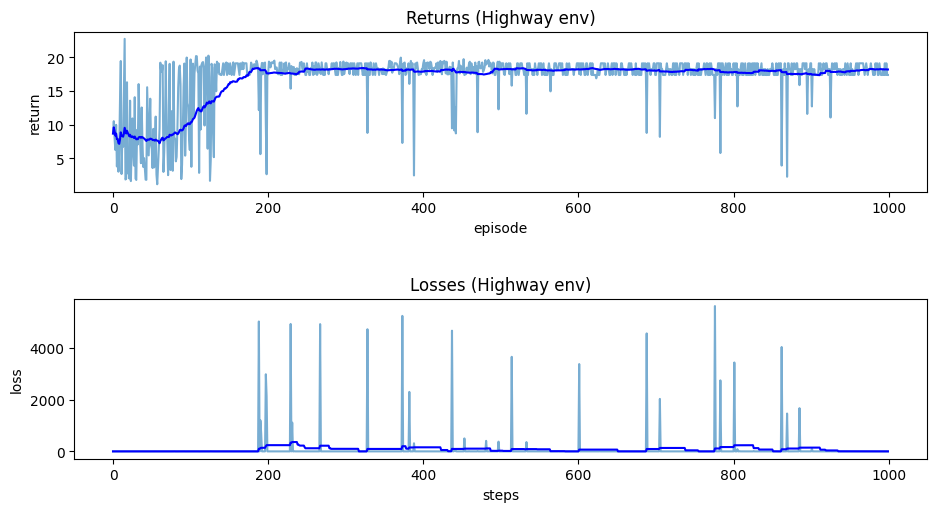

In [28]:
actor_critic_returns = np.load("actor_critic_returns_2.npy")
actor_critic_losses = np.load("actor_critic_losses_2.npy")
plots.draw_plots(actor_critic_returns[0], actor_critic_losses[0], "Highway env")

In [29]:
# Human can play the game manually which can act as a baseline for expected returns. The best I can do is ~39 (undiscounted)
env_render = gym.make("highway-v0", render_mode = "human")
state, _ = env_render.reset()
terminated = False
truncated = False

r = 0
while not (terminated or truncated):
    action, _ = my_agent.get_action(state)
    print(action)
    env_render.render()
    next_state, reward, terminated, truncated, _ = env_render.step(action)
    state = next_state
    r += reward
    # print(f"Returns: {r}", end='\r')
    

env_render.close()

1
4
2
2
4
0
2
0
1
0
